<a href="https://colab.research.google.com/github/nikhilskul7/Predicting-Value-of-Bitcoin-in-INR/blob/master/TradingPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings;
warnings.filterwarnings('ignore');

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen
import json
from pandas.io.json import json_normalize
import seaborn as sn
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as prep
from sklearn.preprocessing import MinMaxScaler

from pandas_datareader import data
import datetime as dt
import os
import tensorflow as tf 
%matplotlib inline


In [ ]:

APIKey="8VOSO8I1MPY69CA5"
cryptocurrencytoconvert="BTC"
smoothing_window_size = 100
market="INR"
EMA = 0.0
gamma = 0.1
window_size = 100
epochstesting=200
numDays=4
time_step = 1000
exmaWindow = 3
smaWindowSmall = 5
smaWindowLarge = 25
emaWindowSmall = 10
emaWindowLarge = 25

normalisationFactor = 1.5

url="https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol="+cryptocurrencytoconvert+"&market="+market+"&apikey="+APIKey


In [ ]:
def createHistodata():
  request="https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol="+cryptocurrencytoconvert+"&market="+market+"&apikey="+APIKey
  response=urlopen(request)
  data=json.loads(response.read())
  df=pd.DataFrame.from_dict(data['Time Series (Digital Currency Daily)'], orient="index")
  df.index = pd.to_datetime(df.index)
  return df



In [ ]:
def cleanData(df):
  df=df.drop(['1b. open (USD)', '2b. high (USD)','3b. low (USD)','4b. close (USD)'], axis=1)
  df=df.rename(columns={"1a. open (INR)": "Open", "2a. high (INR)": "High", "3a. low (INR)": "Low", "4a. close (INR)": "Close", "5. volume": "Volume", "6. market cap (USD)": "Market Cap"})
  df['Open']=df['Open'].astype(float)
  df['High']=df['High'].astype(float)
  df['Low']=df['Low'].astype(float)
  df['Close']=df['Close'].astype(float)
  df['Volume']=df['Volume'].astype(float)
  df['Market Cap']=df['Market Cap'].astype(float)
  df.dropna(inplace=True)
  df.isna().sum()
  
  df=df.drop([ 'Market Cap'], axis=1)
  return df


In [ ]:

#df.info()

In [ ]:
#df.describe()

In [ ]:
''' plt.figure(figsize=(10,7))
sn.heatmap(df.corr(),annot=True,cmap = 'Blues',vmin=-1,vmax=1,center=0,linewidths=2, linecolor='black')
plt.xticks(fontsize=15,rotation=90)
plt.yticks(fontsize=15,rotation=0)
plt.title('Correlation HeatMap')
plt.show() '''

" plt.figure(figsize=(10,7))\nsn.heatmap(df.corr(),annot=True,cmap = 'Blues',vmin=-1,vmax=1,center=0,linewidths=2, linecolor='black')\nplt.xticks(fontsize=15,rotation=90)\nplt.yticks(fontsize=15,rotation=0)\nplt.title('Correlation HeatMap')\nplt.show() "

In [ ]:

def splitData(df):
  train_data = df[:800]
  test_data = df[800:]
  return train_data,test_data



In [ ]:
def removeNullValues(dataframe):
  dataframe.isna().sum()
  dataframe.dropna(inplace=True)
  dataframe.isna().sum()
  dataframe.reset_index(drop=True, inplace=True)
  return dataframe

In [ ]:
def normalizeData(train_data,test_data,df):
  scaler = MinMaxScaler()
  EMA=0.0
  ''' plt.figure(figsize = (18,9))
  plt.plot(range(df.shape[0]),df['Open'],color='b',label='True')
      
  #plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
      
  #plt.xticks(range(0,df.shape[0],50),df['Date'],rotation=45)
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend(fontsize=18)
  plt.show() '''
  
  for di in range(0,100,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])
    scaler.fit(train_data[di+smoothing_window_size:,:])
    train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])
    train_data = train_data.reshape(-1)
    test_data = scaler.transform(test_data).reshape(-1)
    for ti in range(800):
        EMA = gamma*train_data[ti] + (1-gamma)*EMA
        train_data[ti] = EMA
    N = train_data.size
    std_avg_predictions = []
    std_avg_x = []
    mse_errors = []
  
    for pred_idx in range(window_size,N):

        if pred_idx >= N:
            date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
        else:
            date = df.loc[pred_idx,'Date']

        std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
        mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
        std_avg_x.append(date)
    rms = sqrt(mean_squared_error(y_actual, y_predicted))

    print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))
    
    

  


In [ ]:
def createDataset(dataframe, index):
  output_df = pd.DataFrame(dataframe.iloc[:,0])
  output_df = output_df.iloc[index:]
  output_df.reset_index(drop=True, inplace=True)
  lastArray = dataframe.values[-1].tolist()
  
  dataframe.drop(dataframe.tail(index).index,inplace=True)
  return dataframe, output_df,lastArray


In [ ]:
def normaliseInputData(inputdf, maxValue, length):
  openArray = inputdf.iloc[:,0].values
  print("Normalising OPEN prices", end='\n'*2)
  for i in range(length):
    openArray[i] = float(openArray[i]/maxValue)

  exmaArray = inputdf.iloc[:,1].values
  print("Normalising EXMA prices", end='\n'*2)
  for i in range(length):
    exmaArray[i] = float(exmaArray[i]/maxValue)

  smaArray = inputdf.iloc[:,2].values
  print("Normalising SMA prices", end='\n'*2)
  for i in range(length):
    smaArray[i] = float(smaArray[i]/maxValue)

  smaLongArray = inputdf.iloc[:,3].values
  print("Normalising SMA Long prices", end='\n'*2)
  for i in range(length):
    smaLongArray[i] = float(smaLongArray[i]/maxValue)

  emaArray = inputdf.iloc[:,4].values
  print("Normalising EMA prices", end='\n'*2)
  for i in range(length):
    emaArray[i] = float(emaArray[i]/maxValue)

  emaLongArray = inputdf.iloc[:,5].values
  print("Normalising EMA prices", end='\n'*2)
  for i in range(length):
    emaLongArray[i] = float(emaLongArray[i]/maxValue)
    
  inputArray = []
  for i in range(length):
    shapeArray = [openArray[i], exmaArray[i], smaArray[i], smaLongArray[i], emaArray[i], emaLongArray[i]]
    inputArray.append(shapeArray)
  return np.array(inputArray)

def normaliseOutputData(inputdf, outputdf, maxValue, length):
  outputArray = outputdf.iloc[:,0].values
  print("Normalising Output array", end='\n'*2)
  for i in (range(length)):
    outputArray[i] = float(outputArray[i]/maxValue)
  return np.array(outputArray)

In [ ]:
def calculateParameters(simpleDataframe):
  # No formatting required so do nothing here
  dataframe = simpleDataframe
  df_open = pd.DataFrame(dataframe.iloc[:,0])
  #print(df_open.head())
  dataframe['<EXMA>'] = df_open.expanding(min_periods=exmaWindow).mean()
  dataframe['<SMA_SMALL>'] = df_open.rolling(window=smaWindowSmall).mean()
  dataframe['<SMA_LARGE>'] = df_open.rolling(window=smaWindowLarge).mean()
  dataframe['<EMA_SMALL>'] = df_open.ewm(span=emaWindowSmall,adjust=False).mean()
  dataframe['<EMA_LARGE>'] = df_open.ewm(span=emaWindowLarge,adjust=False).mean()
  #print(dataframe.head())
  return dataframe


In [ ]:
def generateDataAndTrain(index,model):
  df=createHistodata()
  df=cleanData(df)

  df= calculateParameters(df)

  df = removeNullValues(df)
  print(df)
  xtrain, ytrain,lastColumn = createDataset(df, index)
  
  lastColumn = xtrain["Open"].tolist()
  maxValue = (max(lastColumn)) * normalisationFactor
  length = len(lastColumn)
  
  input = normaliseInputData(xtrain, maxValue, length)
  output = normaliseOutputData(xtrain, ytrain, maxValue, length)

  trimmedLastArray = []
  for i in range(len(lastColumn)):
    trimmedLastArray.append(float(lastColumn[i]/maxValue))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(input, output, validation_split=0.2, epochs=epochstesting, batch_size=16)
  prediction = model.predict(np.array([input[-1]]))
  predictedValue = float(prediction*maxValue)
  return predictedValue





In [ ]:
output=[]
def trainingModel():
  model = Sequential()
  model.add(Dense(10, activation='relu', input_shape=(6,)))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(5, activation='relu'))
  model.add(Dense(1))
  
  myPredictions = []
  for i in range(numDays):
    myPredictions.append(generateDataAndTrain(i, model))
  return myPredictions
y = trainingModel()


             Open          High  ...    <EMA_SMALL>    <EMA_LARGE>
0    692025.16086  700342.33500  ...  699645.238030  736397.403202
1    696096.06462  696915.94104  ...  698999.933774  733297.300234
2    691905.25206  698279.90364  ...  697709.991644  730113.296528
3    707166.64458  707521.12497  ...  699429.383087  728348.169455
4    693777.32820  709710.21000  ...  698401.736744  725688.873974
..            ...           ...  ...            ...            ...
971  484580.68857  500992.45614  ...  569777.341558  702541.546058
972  437662.62342  501928.49421  ...  545756.483715  682166.244317
973  468022.78215  496872.09000  ...  531623.083430  665693.670304
974  487354.32900  509461.01514  ...  523574.218989  651975.259434
975  530521.49700  545578.29513  ...  524837.360445  642632.662324

[976 rows x 10 columns]
Normalising OPEN prices

Normalising EXMA prices

Normalising SMA prices

Normalising SMA Long prices

Normalising EMA prices

Normalising EMA prices

Normalising Output a

In [ ]:
for i in range(len(y)):
  y[i]=float(y[i])

scaleFactor=(y[0]+max(y))/2

In [ ]:
priceUrl = 'https://www.alphavantage.co/query?function=CURRENCY_EXCHANGE_RATE&from_currency='+cryptocurrencytoconvert+'&to_currency='+market+'&apikey='+APIKey
price = float(requests.get(priceUrl).json()['Realtime Currency Exchange Rate']['5. Exchange Rate'])
print(price)
scaleFactor = price/scaleFactor

for i in range(len(y)):
  y[i] = y[i] * scaleFactor


842868.8639


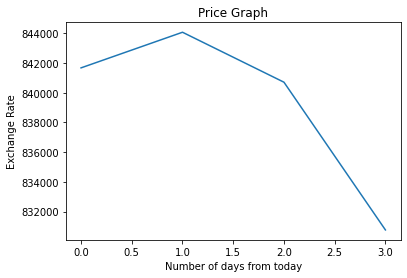

Price Data for the bitcoin
0 Days after today, The price will be: 841669.9043320558
1 Days after today, The price will be: 844067.8234679442
2 Days after today, The price will be: 840704.9839728563
3 Days after today, The price will be: 830762.7759474632


In [ ]:
x = []
for i in range(len(y)):
  x.append(float(i))
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('Number of days from today') 
# naming the y axis 
plt.ylabel('Exchange Rate') 
  
# giving a title to my graph 
plt.title('Price Graph') 
# function to show the plot 
plt.show() 

print('Price Data for the bitcoin')
for i in range(len(y)):
  print(str(int(x[i])) + ' Days after today, The price will be: ' + str(y[i]))

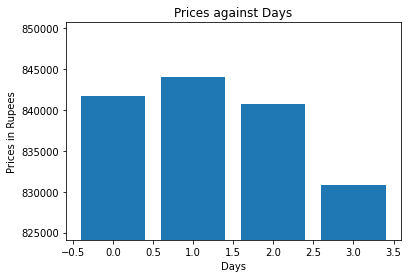

In [ ]:
fig = plt.figure()
low = min(y)
high = max(y)
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.title("Prices against Days")
plt.xlabel("Days")
plt.ylabel("Prices in Rupees")
plt.bar(x,y) 
plt.show()